# Predecir las ventas de la proxima semana con el modelo Random Forest Regressor

En este notebook vamos a entrenar un modelo Random Forest Regressor para predecir el siguiente valor en la serie de tiempo semanal de cantidad vendida (One-Step prediction). Como tenemos la informacion solo de los 5 meses de ventas, hemos elegido este enfoque porque proporciona una predicción para el próximo punto en el tiempo (la proxima semana en nuestro caso), basándose en la información observada hasta el momento. Utilizaremos los 4 primeros meses como conjunto de entrenamiento y el mes de noviembre como evaluación.
El modelo Random Forest tiene en cuenta las relaciones complejas entre las características y la variable objetivo, permitiéndole capturar patrones no lineales en los datos. Cada árbol del bosque contribuye a la predicción final, y la combinación de múltiples árboles ayuda a mitigar el sobreajuste y mejora la generalización del modelo.

IMPORTAMOS LAS LIBRERIAS QUE NECESITAMOS

In [1]:
# Tratamiento de datos
import numpy as np
import pandas as pd
# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
# Modelo
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
# Configuración warnings
import warnings
warnings.filterwarnings('once')

LEEMOS EL DATAFRAME Y ASIGNAMOS A LAS COLUMNAS TIPO DE DATOS 

In [2]:
tienda = pd.read_csv('tienda.csv')
tipos_de_datos = {
    'ID_PRODUCTO': 'object',
    'FECHA_COMPRA': 'datetime64[ns]',
    'CADUCIDAD': 'datetime64[ns]',
    'CANTIDAD': 'float64',
    'PRECIO_TOTAL': 'float64',
    'INDEX_CLIENTES': 'int32',
    'ETIQUETA_CANAL': 'int64',
    'CATEGORIA': 'object',
}
tienda = tienda.astype(tipos_de_datos)
tienda = tienda.loc[tienda['CANTIDAD'] >= 0]
tienda['mes'] = tienda['FECHA_COMPRA'].dt.month
tienda['semana'] = tienda['FECHA_COMPRA'].dt.isocalendar().week
tienda.head()

,ID_PRODUCTO,FECHA_COMPRA,CADUCIDAD,CANTIDAD,PRECIO_TOTAL,INDEX_CLIENTES,ETIQUETA_CANAL,CATEGORIA,mes,semana
0,00026751,2023-07-29,2023-08-01,1.00,8.33,0,1,Salchichon i embutidos,7,30
1,00026751,2023-07-08,2023-10-01,0.59,4.94,5,1,Salchichon i embutidos,7,27
2,00026751,2023-07-08,2023-10-01,0.35,2.93,5,1,Salchichon i embutidos,7,27
3,00026751,2023-07-08,2023-10-01,0.32,2.64,5,1,Salchichon i embutidos,7,27
4,00026751,2023-07-09,2023-10-01,1.20,10.04,5,1,Salchichon i embutidos,7,27


CREAMOS UN NUEVO DATAFRAME CON LAS VENTAS SEMANALES DE CADA PRODUCTO

In [3]:
# Ordenamos el dataframe por productos y fecha de venta
tienda = tienda.sort_values(by=['ID_PRODUCTO', 'FECHA_COMPRA'])

# Establecemos la fecha mínima global en el conjunto de datos y creamos un DataFrame vacío llamado all_combinations. Este DataFrame se utilizará para almacenar todas las combinaciones posibles de fechas.
fecha_min_global = tienda['FECHA_COMPRA'].min()
all_combinations = pd.DataFrame()

# Para cada producto en el conjunto de datos tienda, creamos un rango de fechas que comienza desde la fecha mínima hasta 21 semanas después. Luego, creamos un dataframe (product_combinations_df) con las combinaciones de ID_PRODUCTO y FECHA_COMPRA y lo concatenamos con el DataFrame all_combinations.
for product_id, group in tienda.groupby('ID_PRODUCTO'):
    start_date = fecha_min_global
    end_date = start_date + pd.DateOffset(weeks=21)
    date_range = pd.date_range(start=start_date, end=end_date, freq='W-Mon')
    product_combinations_df = pd.DataFrame({'ID_PRODUCTO': product_id, 'FECHA_COMPRA': date_range})
    all_combinations = pd.concat([all_combinations, product_combinations_df])
    
# Combinamos el dataframe all_combinations con el dataframe original tienda utilizando las columnas 'ID_PRODUCTO' y 'FECHA_COMPRA'. Esto asegura que todas las combinaciones tengan sus respectivos datos. Luego, rellenamos los valores nulos en la columna 'CANTIDAD' con 0, lo que significa que si no hay datos para una combinación específica, se asume que la cantidad vendida es cero.
tienda_organizada = pd.merge(all_combinations, tienda, on=['ID_PRODUCTO', 'FECHA_COMPRA'], how='left')
tienda_organizada['CANTIDAD'] = tienda_organizada['CANTIDAD'].fillna(0)

# Agrupamos los datos por 'ID_PRODUCTO' y por semana ('FECHA_COMPRA' redondeada a semanas) y calculamos la suma de las cantidades vendidas para cada producto. El resultado se almacena en el dataframe tienda_agrupada.
tienda_agrupada = tienda_organizada.groupby(['ID_PRODUCTO', tienda_organizada['FECHA_COMPRA'].dt.to_period('W-Mon')])['CANTIDAD'].sum().reset_index()

# Añadimos información de semana:
tienda_agrupada['semana'] = tienda_agrupada['FECHA_COMPRA'].dt.week

# Ahora podemos eliminar la columna fecha porque tenemos la columna con numero de la semana
tienda_agrupada.drop(['FECHA_COMPRA'], axis=1, inplace=True)

In [4]:
tienda_agrupada.head()

,ID_PRODUCTO,CANTIDAD,semana
0,00000012,0.0,28
1,00000012,0.0,29
2,00000012,1.0,30
3,00000012,1.0,31
4,00000012,0.0,32


PREDECIMOS LA CANTIDAD VENDIDA PARA LA PROXIMA SEMANA CON MODELO RANDOM FOREST REGRESSOR

In [5]:
senial = tienda_agrupada.copy()
# Establecemos varios parámetros que se utilizarán para configurar la estructura de los conjuntos de datos
look_back = 4
N_train = 16 - look_back  # cantidad de instancias que vamos a usar para entrenar
N_test = 4   # cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test
length_total = N_train + N_test + look_back # longitud total de las secuencias

# Inicializamos matrices X e y
X = []
y = []

# Para cada producto único en el dataframe senial, creamos conjuntos de datos X e y. X contendrá secuencias de look_back semanas de ventas, y 'y' contendrá las ventas correspondientes a la semana siguiente
for producto_id in senial['ID_PRODUCTO'].unique():
    producto_data = senial[senial['ID_PRODUCTO'] == producto_id]['CANTIDAD'].values

    for i in range(len(producto_data) - look_back):
        X.append(producto_data[i:i+look_back])
        y.append(producto_data[i+look_back])

# Convertimos las listas X e y en matrices NumPy para que sean compatibles con el entrenamiento de modelos
X = np.array(X)
y = np.array(y)

# Dividimos en conjuntos de entrenamiento y prueba. Esto se hace para preparar los datos para el entrenamiento y la evaluación del modelo de predicción de series temporales
X_train = X[:N_train, :]
y_train = y[:N_train]
print("Training set shapes:", X_train.shape, y_train.shape)

X_test = X[N_train:N_total, :]
y_test = y[N_train:N_total]
print("Testing set shapes:", X_test.shape, y_test.shape)

Training set shapes: (12, 4) (12,)
Testing set shapes: (4, 4) (4,)


ENTRENAMOS EL MODELO

In [6]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculamos las metricas de evaluacion de modelo
MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE))
MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'R^2 en datos de entrenamiento: {r2_train:.4f}')
print(f'R^2 en datos de prueba: {r2_test:.4f}')

mae = mean_absolute_error(y_test, y_test_pred)
print(f'MAE: {mae}')

Error en Train: 0.7966045139846247
Error en Test: 0.7144161331829234
R^2 en datos de entrenamiento: 0.3024
R^2 en datos de prueba: 0.3195
MAE: 0.5649285714285713


GRAFICAMOS LOS VALORES REALES CON LAS PREDICHAS

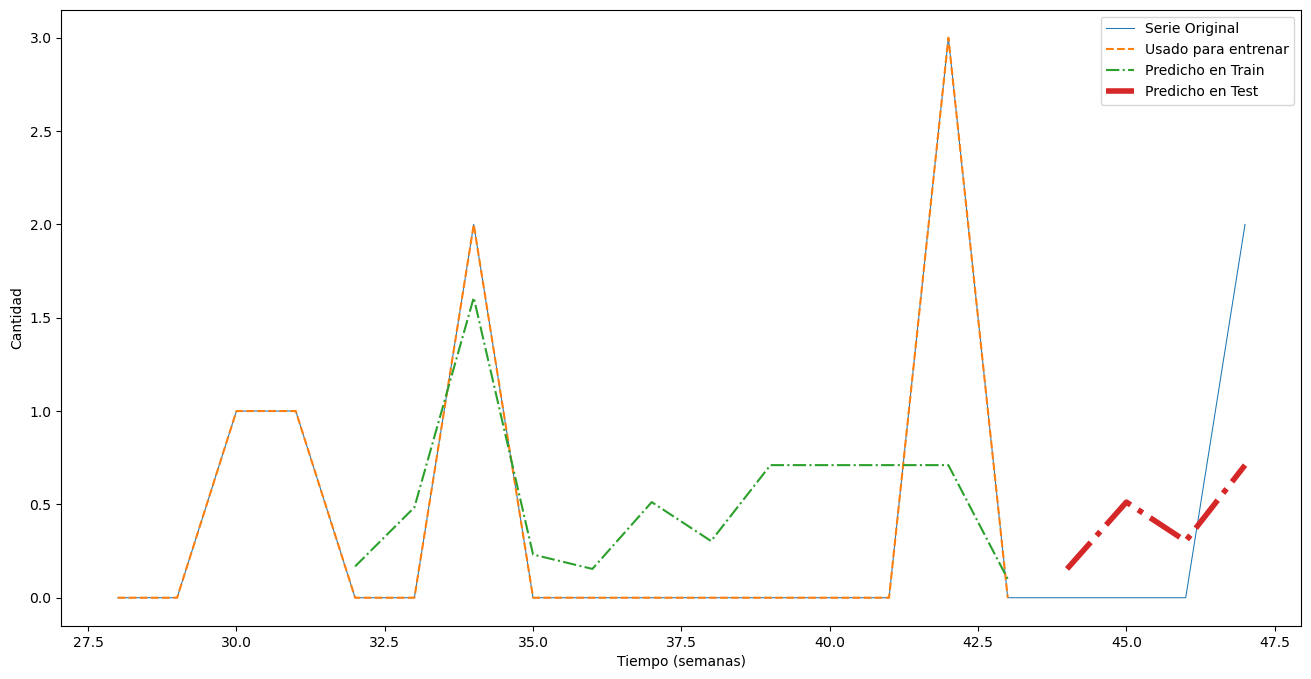

In [7]:
plt.figure(figsize=(16, 8))
plt.plot(senial['semana'][:length_total], senial['CANTIDAD'][:length_total], lw=0.75, label='Serie Original')
plt.plot(senial['semana'][:N_train + look_back], senial['CANTIDAD'][:N_train + look_back], '--', label='Usado para entrenar')
plt.plot(senial['semana'][look_back:look_back + N_train], y_train_pred, '-.', label='Predicho en Train')
plt.plot(senial['semana'][N_train + look_back:length_total], y_test_pred, '-.', lw=4, label='Predicho en Test')
plt.legend()
plt.xlabel('Tiempo (semanas)')
plt.ylabel('Cantidad')
plt.show()

# CONCLUSIÓN

El error en el conjunto de entrenamiento es de aproximadamente 0.7966, mientras que en el conjunto de prueba es de alrededor de 0.7144. Ambos errores son relativamente bajos, lo que indica que el modelo está aprendiendo bien de los datos de entrenamiento y generalizando adecuadamente a nuevos datos.
El R² en datos de entrenamiento es 0.3024, y en datos de prueba es 0.3195. Estos valores sugieren que el modelo explica alrededor del 30% al 32% de la variabilidad en los datos, lo cual es relativamente bajo pero no inusual para problemas de predicción de series temporales. Hay factores no capturados por el modelo que contribuyen a la variabilidad en las ventas.
El MAE en datos de prueba es de aproximadamente 0.565, lo cual indica que, en promedio, las predicciones del modelo difieren en alrededor de 0.565 unidades de la verdad conocida. 
En resumen, el modelo actual tiene un rendimiento decente, pero con solo 5 meses de datos, el modelo tiene dificultades para capturar patrones estacionales, tendencias a largo plazo y comportamientos cíclicos que podrían influir en las ventas. Los modelos de series temporales a menudo se benefician de conjuntos de datos más extensos para aprender mejor las dinámicas temporales.
A medida que se obtienen más datos en el futuro, hay oportunidades para realizar ajustes y mejoras en el modelo existente.